# Introduction
###### Since the graphs are interactive, you must run the program at least once.
###### You should run the program in its own folder since it saves model weights and some charts.
###### To run the program successfully, do the following:
###### - Install the python libraries. You can comment the first cell out after installation.
###### - Add vscode extensions: Python, Pylance, and some relevant Jupyter Notebook extensions. Most will be automatically recommendend, so add them.
###### - OPTIONAL: reduce the values of the model parameters to train it faster, but with less accuracy.
######
###### There are a couple of things you can change...
###### - The stock, and the start/end date
###### - Data acquisition method: run the program the first time, then set load_from_yf and save_data_from_yf to False to use downloaded data.
###### - Technical Indicators (see section 'Technical Indicators') 
###### - Model parameters (see section 'Model Creation and Training' and 'Model Fitting')
###### - Other: test_data_percent, sliding_window_size

##### Library Installation

In [325]:
# uncomment this cell to install the following libraries.
# follow the below link to use gpu. prefer to use windows native (with tensorflow 2.10) because it is easier to install.
# https://www.tensorflow.org/install/pip
#%pip install numpy
#%pip install pandas
#%pip install ta
#%pip install matplotlib
#%pip install scikit-learn
#%pip install tensorflow
#%pip install ipympl

##### Imports

In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras import layers
from keras import Input
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from ta import momentum
from ta import volume
from ta import volatility
from ta import trend


##### Miscellaneous

In [327]:
# Used for interactive plots (zooming in)
%matplotlib widget

np.set_printoptions(threshold=np.inf, linewidth=300)

In [328]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Inputs

##### Stock and Timeframe

In [329]:
start_date = '2013-09-01'
end_date = '2023-09-01'
stock_ticker = 'AMZN'

# Data acquisition method
##### After running the program at least once, you can set load_from_yf and save_data_from_yf to False to use the downloaded data instead.

In [330]:
load_from_yf = False        # set to true if the data should be downloaded from yahoo finance.
save_data_from_yf = True   # set to true if the data should be saved. If data is downloaded, you can set this to false.

load_from_file = True   # set to true if the data is loaded in the given filepath.
filepath = 'stock_data.csv'

##### Data Gathering Option 1: Yahoo Finance

In [331]:
df = pd.DataFrame()

In [332]:
# get the stock from yahoo finance
if load_from_yf:
    start = pd.to_datetime([start_date]).astype('int64')[0]//10**9    # convert to unix timestamp.
    end = pd.to_datetime([end_date]).astype('int64')[0]//10**9      # convert to unix timestamp.
    url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock_ticker + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
    df = pd.read_csv(url)
    df

In [333]:
# Save the data
if save_data_from_yf and load_from_yf: # this ensures that we don't save if there wasn't any data downloaded.
    df.to_csv(filepath, index=False)

##### Data Gathering Option 2: Load from file

In [334]:
# Load the csv at the file path
df_from_file = pd.read_csv(filepath)

In [335]:
# Set df to df_from_file
if load_from_file:
    df = df_from_file

# Data Operations

##### Technical Indicators

In [336]:
# To add a new TA column, simply follow the examples shown. Some TA might have more than one function, such as MACD - it is not necessary to use them, but might as well have them!
# Use the ta library documentation to find more indicators for each of the below categories.
# Hover over the TA class to see what data is needed, for example: open, high, low, close, volume
# Some TA classes needs a window, which you can optionally add as an argument.

# Momentum
df['rsi'] = momentum.RSIIndicator(df['Close'], window=10).rsi()
df['awesome_oscillator'] = momentum.AwesomeOscillatorIndicator(df['High'], df['Low'], window1=5, window2=30).awesome_oscillator()

# Volume
df['force_index'] = volume.ForceIndexIndicator(df['Close'], df['Volume'], window=10).force_index()
df['ease_of_movement'] = volume.EaseOfMovementIndicator(df['High'], df['Low'], df['Volume'], window=10).ease_of_movement()
df['ease_of_movement_signal'] = volume.EaseOfMovementIndicator(df['High'], df['Low'], df['Volume'], window=10).sma_ease_of_movement()

# Volatility
df['bbands_upper'] = volatility.BollingerBands(df['Close'], window=10).bollinger_hband()
df['bbands_middle'] = volatility.BollingerBands(df['Close'], window=10).bollinger_mavg()
df['bbands_lower'] = volatility.BollingerBands(df['Close'], window=10).bollinger_lband()
df['atr'] = volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=10).average_true_range()

# Trend
df['macd'] = trend.MACD(df['Close'], window_slow=20, window_fast=10, window_sign=9).macd()
df['macd_signal'] = trend.MACD(df['Close'], window_slow=20, window_fast=10, window_sign=9).macd_signal()
df['aroon'] = trend.AroonIndicator(df['Close'], window=20).aroon_indicator()
df['aroon_up'] = trend.AroonIndicator(df['Close'], window=20).aroon_up()
df['aroon_down'] = trend.AroonIndicator(df['Close'], window=20).aroon_down()



In [337]:
# Convert the 'Date' column to a pandas datetime object (if not already converted)
df['Date'] = pd.to_datetime(df['Date'])

# Preprocessing: Scale down data as needed
df['Volume'] = df['Volume'] / 1000000
df['force_index'] = df['force_index'] / 1000000


# Drop NaN values, which typically includes the first few rows where TA values are NaN
df.dropna(inplace=True)

In [338]:
print(df.shape)
print(df.columns)

# Listing some technical indicators here as an example. The indices after "Volume" should match the array here.
# Note that this is not exhaustive if we add more TA.
# [...,'rsi','macd','macd_signal','bbands_upper','bbands_lower','bbands_middle']


(2488, 21)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'rsi',
       'awesome_oscillator', 'force_index', 'ease_of_movement',
       'ease_of_movement_signal', 'bbands_upper', 'bbands_middle',
       'bbands_lower', 'atr', 'macd', 'macd_signal', 'aroon', 'aroon_up',
       'aroon_down'],
      dtype='object')


In [339]:
#df.head(45) # check to see if indicators are properly calculated.
df.isnull().sum()   # check to see if any null values are left.

Date                       0
Open                       0
High                       0
Low                        0
Close                      0
Adj Close                  0
Volume                     0
rsi                        0
awesome_oscillator         0
force_index                0
ease_of_movement           0
ease_of_movement_signal    0
bbands_upper               0
bbands_middle              0
bbands_lower               0
atr                        0
macd                       0
macd_signal                0
aroon                      0
aroon_up                   0
aroon_down                 0
dtype: int64

In [340]:
df_copy = df.copy() # used for plotting values
df.drop(['Date', 'Adj Close'], axis=1, inplace=True)

In [341]:
# Swap close price with open price, since predicting the price the stock closes at is more helpful.
col_loc = df.columns.get_loc('Close')
if col_loc != 0:
    cols = list(df.columns)
    a, b = cols.index('Close'), cols.index(df.columns[0])
    cols[b], cols[a] = cols[a], cols[b]
    df = df[cols]

In [342]:
# Scale the data
df_columns = df.columns

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)    # fit and transform to all data
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df_columns

scaler_price = MinMaxScaler(feature_range=(0, 1))   # fit to data, used by graphs to plot prices instead of values in the (0, 1) range
scaler_price.fit(df[['Close']])

df_scaled

,Close,High,Low,Open,Volume,rsi,awesome_oscillator,force_index,ease_of_movement,ease_of_movement_signal,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down
0,0.000758,0.000000,0.000992,0.000000,0.172153,0.742481,0.747264,0.860420,0.516252,0.564710,0.000000,0.000000,0.000000,0.050081,0.756657,0.720479,0.736842,1.000000,0.526316
1,0.004085,0.003866,0.002381,0.001509,0.218478,0.778835,0.756389,0.862279,0.519332,0.569175,0.001952,0.003267,0.004566,0.049081,0.764619,0.728623,0.763158,1.000000,0.473684
2,0.001318,0.000459,0.000827,0.001181,0.174987,0.706309,0.761472,0.852594,0.512072,0.569920,0.000499,0.006218,0.011983,0.047695,0.767156,0.735738,0.763158,0.947368,0.421053
3,0.003229,0.002031,0.002646,0.001542,0.102839,0.730761,0.765450,0.851367,0.517901,0.565989,0.001409,0.008185,0.015005,0.042864,0.769959,0.742090,0.763158,0.894737,0.368421
4,0.005864,0.004095,0.004829,0.003478,0.150634,0.763268,0.766646,0.852128,0.517641,0.563741,0.002894,0.010057,0.017247,0.038456,0.773580,0.748026,0.842105,1.000000,0.315789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2483,0.912631,0.913803,0.912750,0.914526,0.079277,0.648608,0.724355,0.856145,0.520558,0.716884,0.899166,0.900299,0.888836,0.229606,0.747649,0.678755,0.789474,1.000000,0.421053
2484,0.906207,0.905252,0.911063,0.906520,0.071659,0.588836,0.746193,0.846594,0.491013,0.679731,0.901900,0.903556,0.892583,0.213628,0.753788,0.692689,0.789474,0.947368,0.368421
2485,0.896258,0.896897,0.893336,0.898875,0.103678,0.504679,0.750379,0.833287,0.396830,0.620478,0.901015,0.906211,0.898823,0.219957,0.748522,0.702594,0.789474,0.894737,0.315789
2486,0.891744,0.887200,0.889830,0.881517,0.102850,0.469194,0.740126,0.828471,0.479064,0.584706,0.901076,0.906809,0.899964,0.213750,0.739932,0.708492,0.789474,0.842105,0.263158


In [343]:
features = df_scaled    #df_scaled.drop(['Date', 'Adj Close'], axis=1)   # All but Date and Adj Close
target = df_scaled[['Close']]    # Prediction target. 

In [344]:
features

,Close,High,Low,Open,Volume,rsi,awesome_oscillator,force_index,ease_of_movement,ease_of_movement_signal,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down
0,0.000758,0.000000,0.000992,0.000000,0.172153,0.742481,0.747264,0.860420,0.516252,0.564710,0.000000,0.000000,0.000000,0.050081,0.756657,0.720479,0.736842,1.000000,0.526316
1,0.004085,0.003866,0.002381,0.001509,0.218478,0.778835,0.756389,0.862279,0.519332,0.569175,0.001952,0.003267,0.004566,0.049081,0.764619,0.728623,0.763158,1.000000,0.473684
2,0.001318,0.000459,0.000827,0.001181,0.174987,0.706309,0.761472,0.852594,0.512072,0.569920,0.000499,0.006218,0.011983,0.047695,0.767156,0.735738,0.763158,0.947368,0.421053
3,0.003229,0.002031,0.002646,0.001542,0.102839,0.730761,0.765450,0.851367,0.517901,0.565989,0.001409,0.008185,0.015005,0.042864,0.769959,0.742090,0.763158,0.894737,0.368421
4,0.005864,0.004095,0.004829,0.003478,0.150634,0.763268,0.766646,0.852128,0.517641,0.563741,0.002894,0.010057,0.017247,0.038456,0.773580,0.748026,0.842105,1.000000,0.315789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2483,0.912631,0.913803,0.912750,0.914526,0.079277,0.648608,0.724355,0.856145,0.520558,0.716884,0.899166,0.900299,0.888836,0.229606,0.747649,0.678755,0.789474,1.000000,0.421053
2484,0.906207,0.905252,0.911063,0.906520,0.071659,0.588836,0.746193,0.846594,0.491013,0.679731,0.901900,0.903556,0.892583,0.213628,0.753788,0.692689,0.789474,0.947368,0.368421
2485,0.896258,0.896897,0.893336,0.898875,0.103678,0.504679,0.750379,0.833287,0.396830,0.620478,0.901015,0.906211,0.898823,0.219957,0.748522,0.702594,0.789474,0.894737,0.315789
2486,0.891744,0.887200,0.889830,0.881517,0.102850,0.469194,0.740126,0.828471,0.479064,0.584706,0.901076,0.906809,0.899964,0.213750,0.739932,0.708492,0.789474,0.842105,0.263158


In [345]:
target

,Close
0,0.000758
1,0.004085
2,0.001318
3,0.003229
4,0.005864
...,...
2483,0.912631
2484,0.906207
2485,0.896258
2486,0.891744


##### Test Data Percent

In [346]:
dataset = df_scaled.to_numpy()
test_data_percent = 0.9   # percentage of data used for testing (no training or validation)
train_data_len = math.ceil(len(dataset) * test_data_percent)

In [347]:
print(len(df_scaled[0:train_data_len]))
print(len(dataset[0:train_data_len]))

2240
2240


##### Train Data Setup

In [348]:
train_x = features[0:train_data_len].to_numpy()
train_y = target[0:train_data_len].to_numpy()

In [349]:
print(train_x.shape)
print(train_y.shape)

(2240, 19)
(2240, 1)


In [350]:
# preparing the train data as a sliding window
x_train_sw = []
y_train_sw = []

# The sliding window size (in days) we use as input. There are 5 trading days in a week, so 60 trading days = 12 weeks = 3 months
sliding_window_size = 60 
for i in range(sliding_window_size, len(train_x)):
    x_train_sw.append(train_x[i-sliding_window_size:i,:])
    y_train_sw.append(train_y[i:i+1, 0])

x_train_sw, y_train_sw = np.array(x_train_sw), np.array(y_train_sw)   # convert to numpy array

# Transformer Model

In [351]:
def transformer_encoder(
    inputs, 
    head_size, 
    num_heads, 
    ff_dim, 
    dropout=0.0
):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [352]:
# This function builds the model.
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.0,
    mlp_dropout=0.0,
):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)    # this tells us that the output is one prediction step.
    return Model(inputs, outputs)

In [353]:
input_shape = x_train_sw.shape[1:]
print(x_train_sw.shape)     # (number of data values, window, column count)
print(input_shape)          # (window, column count)
print(y_train_sw.shape)     # (number of data values, target)

(2180, 60, 19)
(60, 19)
(2180, 1)


##### Model Checkpoint

In [354]:
# Adding EarlyStopping callback (for lots of epochs)
callbacks = [EarlyStopping(patience=10, restore_best_weights=True)]

# Define the path to save the best weights. The best weights will be used for stock prediction.
checkpoint_path = 'best_weights.h5'

# Adding ModelCheckpoint callback
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)


##### Model Creation and Training

In [355]:
# The model is ready to be built and trained!
# You can tune the model here.
input_shape = (sliding_window_size, input_shape[1])
model = build_model(
    input_shape,
    head_size=256,
    num_heads=8,
    ff_dim=16,
    num_transformer_blocks=8,
    mlp_units=[256],
    mlp_dropout=0.05,
    dropout=0.05,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    metrics=['mse', 'mae', 'mape']
)

model.summary()

# General guidelines for hyperparameters
# - head_size and mlp_units should be large values (i.e. 256 for head_size and mlp_units, 8 num_heads, ff_dim, num_transformer_blocks)
# - you can't just keep increasing the hyperparameter values, memory is your constraint.
# - dropout at 0.05 seems to give better results than higher values, but needs more testing.

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 60, 19)]     0           []                               
                                                                                                  
 layer_normalization_96 (LayerN  (None, 60, 19)      38          ['input_6[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_48 (Multi  (None, 60, 19)      161811      ['layer_normalization_96[0][0]', 
 HeadAttention)                                                   'layer_normalization_96[0][0]'] 
                                                                                            

##### Model Fitting

In [356]:
# Train the model with the callback
train_validation_split = 0.2  # 0.2 means 80% train and 20% validation. Higher = less train, more validation.
history = model.fit(
            x_train_sw,
            y_train_sw,
            validation_split=train_validation_split,
            epochs=20,
            batch_size=128,
            callbacks=[checkpoint]
          )

# Load the best weights into the model
model.load_weights('best_weights.h5')

Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 0.2292 - mse: 0.2292 - mae: 0.3638 - mape: 57905.2891
Epoch 1: val_loss improved from inf to 0.51363, saving model to best_weights.h5
14/14 [==============================] - 11s 282ms/step - loss: 0.2292 - mse: 0.2292 - mae: 0.3638 - mape: 57905.2891 - val_loss: 0.5136 - val_mse: 0.5136 - val_mae: 0.5044 - val_mape: 62.0888
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 0.0272 - mse: 0.0272 - mae: 0.1332 - mape: 203915.4375
Epoch 2: val_loss improved from 0.51363 to 0.29589, saving model to best_weights.h5
14/14 [==============================] - 3s 224ms/step - loss: 0.0272 - mse: 0.0272 - mae: 0.1332 - mape: 203915.4375 - val_loss: 0.2959 - val_mse: 0.2959 - val_mae: 0.4144 - val_mape: 49.6590
Epoch 3/20
14/14 [==============================] - ETA: 0s - loss: 0.0151 - mse: 0.0151 - mae: 0.0968 - mape: 7263.6289
Epoch 3: val_loss improved from 0.29589 to 0.24038, saving model to best_weights.h5


# Testing and Validation

##### Test Data Setup

In [357]:
test_x = features[train_data_len:].to_numpy()
test_y = target[train_data_len:].to_numpy()

In [358]:
print(test_x.shape)
print(test_y.shape)

(248, 19)
(248, 1)


In [359]:
# preparing the test data as a sliding window
x_test_sw = []  # features
y_test_sw = []  # target
y_remaining = []    # features remaining

for i in range(sliding_window_size, len(test_x)):
    x_test_sw.append(test_x[i-sliding_window_size:i,:])
    y_test_sw.append(test_y[i:i+1,0])
    y_remaining.append(test_x[i:i+1,1:])

x_test_sw = np.array(x_test_sw)
y_test_sw = np.array(y_test_sw)
y_remaining = np.array(y_remaining)

In [360]:
print(x_test_sw.shape)
print(y_test_sw.shape)
print(y_remaining.shape)
print(y_remaining.size)
print(y_remaining.shape[0])

(188, 60, 19)
(188, 1)
(188, 1, 18)
3384
188


##### Model Evaluation

In [361]:
model.evaluate(x_test_sw, y_test_sw, verbose=1)

6/6 [==============================] - 0s 31ms/step - loss: 0.0774 - mse: 0.0774 - mae: 0.2583 - mape: 32.0602


[0.07741199433803558,
 0.07741199433803558,
 0.2582889795303345,
 32.06023025512695]

##### Performing Prediction Steps

In [362]:
# This function performs a single step prediction and adds supporting values from data for another prediction. Calling this multiple times resembles a multistep model.
# Prediction steps uses ground truth data (except target) per step.
def perform_prediction_step_on_predicted_price(input_data, remaining_y):
    # reshape the input to (1, sliding_window_size, data columns)
    test_input = np.reshape(input_data, (1, input_data.shape[0], input_data.shape[1]))
    #print('####################')
    #print('test input')
    #print(test_input.shape) # (1, sliding_window_size, data columns)

    # perform a prediction step
    prediction_value = model.predict(test_input, verbose=0)
    
    #print('predicted value')
    #print(prediction_value)
    #print('value from test (actual value)')
    #print(input_data[0][0]) # this is the first item (the target) in the first row (before the window gets shifted


    # concatenate the prediction value to beginning of the data columns
    final = np.concatenate((prediction_value, remaining_y), axis=1)

    #print('remaining y')
    #print(remaining_y.shape) # (1, prediction + one row of data columns)

    #print('final')
    #print(final.shape)       # (1, data columns)

    # concatenate the input data to the beginning of
    test_x = np.concatenate((input_data, final), axis=0)

    #print('test_x before shift')
    #print(test_x.shape)     # (1 + sliding_window_size, data columns)

    test_x = test_x[1:]     # shifting the sliding window one step forward

    #print('test_x after shift')
    #print(test_x.shape)     # (sliding_window_size, data columns)
    
    return test_x, prediction_value

In [363]:
# EXPERIMENTAL: recommend not to use, since TA values will NOT be retroactively updated in accordance with predictions.
# this one is different from the previous in that it allows the model to make predictions on the previous ground truth target, instead on predicting on its old prediction.
# in essence, this replicates true backtesting.
def perform_prediction_step_on_actual_price(input_data, remaining_y):
    # reshape the input to (1, sliding_window_size, data columns)
    test_input = np.reshape(input_data, (1, input_data.shape[0], input_data.shape[1]))
    #print('####################')
    #print('test input')
    #print(test_input.shape) # (1, sliding_window_size, data columns)

    # perform a prediction step
    prediction_value = model.predict(test_input, verbose=0)
    
    #print('predicted value')
    #print(prediction_value)
    #print(prediction_value.shape)
    #print('value from test (actual value)')
    last_ground_price = np.reshape(input_data[0][0], (1, 1))
    #print(last_ground_price) # this is the first item (the target) in the first row (before the window gets shifted


    # concatenate the prediction value to beginning of the data columns
    final = np.concatenate((last_ground_price, remaining_y), axis=1)

    #print('remaining y')
    #print(remaining_y.shape) # (1, prediction + one row of data columns)

    #print('final')
    #print(final.shape)       # (1, data columns)

    # concatenate the input data to the beginning of
    test_x = np.concatenate((input_data, final), axis=0)

    #print('test_x before shift')
    #print(test_x.shape)     # (1 + sliding_window_size, data columns)

    test_x = test_x[1:]     # shifting the sliding window one step forward

    #print('test_x after shift')
    #print(test_x.shape)     # (sliding_window_size, data columns)
    
    return test_x, prediction_value

In [364]:
# This function performs a single step prediction without adding supporting values. 
# Only use this if you want to predict a single step into the future!
def perform_prediction_step_tomorrow(input_data):
    test_input = np.reshape(input_data,(1,input_data.shape[0], input_data.shape[1]))
    prediction_value = model.predict(test_input)
    return prediction_value

In [365]:
prediction_values = []
test_x = x_test_sw[0].copy()

# Multistep prediction with the available data
for i in range(y_remaining.shape[0]):
    test_x, prediction = perform_prediction_step_on_actual_price(test_x, y_remaining[i])
    prediction_values.append(prediction)

# Single step prediction into the future!
prediction = perform_prediction_step_tomorrow(test_x)
prediction_values.append(prediction)
print('Today is ' + end_date + '. The next trading day\'s predicted price: $' + str(scaler_price.inverse_transform(prediction)[0][0]))


1/1 [==============================] - 0s 31ms/step
Today is 2023-09-01. The next trading day's predicted price: $290.9385


In [366]:
pred_vals = np.array(prediction_values) # convert to numpy array
pred_vals = pred_vals.squeeze(1)
pred_vals.shape

(189, 1)

##### RMSE

In [367]:
rmse = mean_squared_error(pred_vals[:-1], y_test_sw, squared=False)
print("RMSE:", rmse)

RMSE: 0.2526536683945331


# Outputs

#### Preparation for Output

In [368]:
# we are concatenating the train data in order to show predicted values on top of ground truth values. This includes the single prediction step into the future.
predicted = np.concatenate((y_train_sw, pred_vals), axis=0)
ground_truth = np.concatenate((y_train_sw, y_test_sw), axis=0)

In [369]:
print(predicted.shape)
print(ground_truth.shape)
print(pred_vals.shape)

(2369, 1)
(2368, 1)
(189, 1)


## Prediction vs Ground Truth Graph

In [370]:
def plot_prediction_vs_gt():
    # Use the unscaled data to see prices
    scaler_pred = scaler_price.inverse_transform(predicted)
    scaler_ground_truth = scaler_price.inverse_transform(ground_truth)

    plt.figure(figsize=(15, 6))

    # Adding the predicted, ground truth, and tomorrow's prediction
    plt.plot(scaler_pred.flatten(), label='Next Trading Day Prediction', color='#0000FF')
    plt.plot(scaler_pred[:-1].flatten(), label='Predicted', color='#00FF00')
    plt.plot(scaler_ground_truth.flatten(), label='Ground Truth', color='#FF8800')

    # Adding vertical lines indicating different data usages
    plt.axvline(x=0, label='Keras Train', color='#FF0000', ls=(0, (1, 4)))  # this data was used for model training by keras.
    plt.axvline(x=train_data_len * (1-train_validation_split), label='Keras Validation', color='#00FF00', ls=(0, (1, 4)))   # this data was used for model validation by keras.
    plt.axvline(x=ground_truth.size-pred_vals.size, label='Prediction Start', color='#0000FF', ls=(0, (1, 4)))   # this is the test data - predictions are made on it, and we can compare it to ground truth.
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1,2,0,3,4,5]

    plt.xlabel('Date (' + start_date + ' to ' + end_date + ') + 1')
    plt.ylabel('Stock Price ($)')
    plt.title('Prediction vs Ground Truth')
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    plt.savefig('Prediction.png')
    plt.show()


## Daily Closing Prices

In [371]:
def plot_daily_close():
    # Plotting daily closing prices
    plt.figure(figsize=(12, 6))
    plt.plot(df_copy['Date'], df_copy['Close'], linestyle='-')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(stock_ticker + ' Daily Closing Prices')
    plt.show()

## Daily Stock Returns

In [372]:
df_copy['Daily_Return'] = df_copy['Close'].pct_change()
df_copy.dropna(inplace=True)
df_copy

,Date,Open,High,Low,Close,Adj Close,Volume,rsi,awesome_oscillator,force_index,...,bbands_upper,bbands_middle,bbands_lower,atr,macd,macd_signal,aroon,aroon_up,aroon_down,Daily_Return
30,2013-10-22,174.910004,175.929993,174.429993,175.410004,146.200943,126.6630,72.081297,3.479498,98.540436,...,177.196176,171.516000,165.835824,1.678245,1.309862,0.524809,50.0,100.0,50.0,0.005791
31,2013-10-23,174.809998,174.889999,173.960007,174.570007,145.500854,105.4840,66.410722,3.899498,64.513767,...,176.746261,172.413000,168.079739,1.655420,1.381976,0.696242,50.0,95.0,45.0,-0.004789
32,2013-10-24,174.919998,175.369995,174.509995,175.149994,145.984192,70.3500,68.322566,4.228164,60.202552,...,177.028009,173.011000,168.993991,1.575878,1.461643,0.849323,50.0,90.0,40.0,0.003322
33,2013-10-25,175.509995,176.000000,175.169998,175.949997,146.651001,93.6250,70.864182,4.326998,62.874866,...,177.487581,173.580000,169.672419,1.503291,1.564573,0.992373,65.0,100.0,35.0,0.004568
34,2013-10-28,175.889999,176.470001,175.699997,176.229996,146.884399,84.9790,71.745770,4.486499,55.769261,...,177.873436,174.109000,170.344563,1.429962,1.637917,1.121482,70.0,100.0,30.0,0.001591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2023-09-01,453.170013,453.670013,449.679993,451.190002,449.604095,58.8757,61.899313,0.832502,76.990314,...,455.004464,444.185004,433.365544,4.651016,0.827526,-0.676898,55.0,100.0,45.0,0.001865
2513,2023-09-05,450.730011,451.059998,449.170013,449.239990,447.660950,55.1662,57.225892,2.637003,43.433030,...,455.850762,445.175003,434.499244,4.387914,1.002008,-0.341117,55.0,95.0,40.0,-0.004322
2514,2023-09-06,448.399994,448.510010,443.809998,446.220001,444.651550,70.7585,50.645986,2.982837,-3.316592,...,455.576968,445.982004,436.387039,4.492122,0.852348,-0.102424,55.0,90.0,35.0,-0.006722
2515,2023-09-07,443.109985,445.549988,442.750000,444.850006,443.286377,70.3554,47.871544,2.135668,-20.238402,...,455.595742,446.164005,436.732267,4.389909,0.608187,0.039698,55.0,85.0,30.0,-0.003070


In [373]:
def plot_daily_returns():
    plt.figure(figsize=(12, 6))

    # Plotting daily stock returns
    plt.plot(df_copy['Date'][1:], df_copy['Daily_Return'][1:], linestyle='-')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title('Daily Stock Returns')
    plt.show()

## Loss from Training and Validation

In [374]:
# Accessing training and validation loss from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Generating a list of epochs (x-axis)
epochs = range(1, len(training_loss) + 1)

In [375]:
def plot_loss_chart():
    plt.figure(figsize=(8, 4))

    # Plotting the training and validation loss over iterations
    plt.plot(epochs, training_loss, label='Training Loss', linestyle='-')
    plt.plot(epochs, validation_loss, label='Validation Loss', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

## Pie Chart

In [376]:
# Getting data for pie chart
pie_chart_data = pd.DataFrame({
    'Predicted': pred_vals[:-1].flatten(),  # since the last value is done into the future, it does not have any TA associated with it.
    'Ground_Truth': y_test_sw.flatten()
})

pie_chart_data

,Predicted,Ground_Truth
0,0.527511,0.731600
1,0.508828,0.721849
2,0.527723,0.740528
3,0.488436,0.750478
4,0.525684,0.742011
...,...,...
183,0.402994,0.912631
184,0.406653,0.906207
185,0.419942,0.896258
186,0.400708,0.891744


In [377]:
# Calculating all of the necessary things for the pie chart.

# tolerance = ((pred - gt) / gt) * 100 < tolerance_percent  # determines if the model predicted under some tolerance percent
# gt movement = gtcurr - gtprev > 0                         # determines if the ground truth movement was up or down
# pred movement = pred - gtprev > 0                         # determines if the model prediction was up or down
# if the gt movement and prediction movement are both T or F, then the model predicted correctly upwards/downards.
# if the gt movement and prediction movement are T/F or F/T, then the model predicted incorrectly downwards for T/F and incorrectly upwards for F/T
# if the tolerance is under the %, then the model predicted accurately.
# if the tolerance is over the %, then the model predicted inaccurately.

predicted_values = np.array(pie_chart_data['Predicted'])
ground_truth_values = np.array(pie_chart_data['Ground_Truth'])

tolerance_percent = 2   # integer used to determine if the model was accurate or not. 1 = 1% tolerance
tolerance = []
ground_truth_movement = []  # T is up, F is down
prediction_movement = []    # T is up, F is down

# append bool values to each array based on the requirements
for i in range(1, ground_truth_values.size):
    tolerance.append(True if abs((predicted_values[i] - ground_truth_values[i]) / ground_truth_values[i]) * 100 < tolerance_percent else False)
    ground_truth_movement.append(True if ground_truth_values[i] - ground_truth_values[i-1] > 0 else False)
    prediction_movement.append(True if predicted_values[i] - ground_truth_values[i-1] > 0 else False)

In [378]:
print(len(tolerance))
print(len(ground_truth_movement))
print(len(prediction_movement))

187
187
187


In [379]:
# Categorizations of model movement prediction, ground truth movement, and tolerance 

correct = 0
incorrect = 0
under = 0
over = 0

correct_upwards_under = 0
correct_upwards_over = 0
correct_downwards_under = 0
correct_downwards_over = 0
incorrect_upwards_under = 0
incorrect_upwards_over = 0
incorrect_downwards_under = 0
incorrect_downwards_over = 0

In [380]:
# TODO research a cleaner way of doing this...
for i in range(0, ground_truth_values.size - 1):
    correct += int((ground_truth_movement[i] == True and prediction_movement[i] == True) or (ground_truth_movement[i] == False and prediction_movement[i] == False))     # model predicted correct direction
    incorrect += int((ground_truth_movement[i] == True and prediction_movement[i] == False) or (ground_truth_movement[i] == False and prediction_movement[i] == True))  # model predicted wrong direction
    under += int(tolerance[i] == True)  # model predicted under tolerance
    over += int(tolerance[i] == False)  # model predicted over tolerance

    correct_upwards_under += int(ground_truth_movement[i] == True and prediction_movement[i] == True and tolerance[i] == True)         # model predicted correctly upwards under tolerance
    correct_upwards_over += int(ground_truth_movement[i] == True and prediction_movement[i] == True and tolerance[i] == False)         # model predicted correctly updwards over tolerance
    correct_downwards_under += int(ground_truth_movement[i] == False and prediction_movement[i] == False and tolerance[i] == True)     # model predicted correctly downwards under tolerance
    correct_downwards_over += int(ground_truth_movement[i] == False and prediction_movement[i] == False and tolerance[i] == False)     # model predicted correctly downwards over tolerance
    incorrect_upwards_under += int(ground_truth_movement[i] == False and prediction_movement[i] == True and tolerance[i] == True)      # model predicted incorrectly upwards under tolerance
    incorrect_upwards_over += int(ground_truth_movement[i] == False and prediction_movement[i] == True and tolerance[i] == False)      # model predicted incorrectly upwards over tolerance
    incorrect_downwards_under += int(ground_truth_movement[i] == True and prediction_movement[i] == False and tolerance[i] == True)    # model predicted incorrectly downwards under tolerance
    incorrect_downwards_over += int(ground_truth_movement[i] == True and prediction_movement[i] == False and tolerance[i] == False)    # model predicted incorrectly downwards over tolerance

In [381]:
tol_per = str(tolerance_percent)
print('Number of times the model predicted CORRECT direction: ' + str(correct))
print('Number of times the model predicted INCORRECT direction: ' + str(incorrect))
print('Number of times the model predicted UNDER ' + tol_per + '% tolerance: ' + str(under))
print('Number of times the model predicted OVER ' + tol_per + '% tolerance: ' + str(over))

print('Number of times the model CORRECTLY predicted UPWARD movement UNDER ' + tol_per + '% tolerance: ' + str(correct_upwards_under))
print('Number of times the model CORRECTLY predicted UPWARD movement OVER ' + tol_per + '% tolerance: ' + str(correct_upwards_over))
print('Number of times the model CORRECTLY predicted DOWNWARD movement UNDER ' + tol_per + '% tolerance: ' + str(correct_downwards_under))
print('Number of times the model CORRECTLY predicted DOWNWARD movement OVER ' + tol_per + '% tolerance: ' + str(correct_downwards_over))
print('Number of times the model INCORRECTLY predicted UPWARD movement UNDER ' + tol_per + '% tolerance: ' + str(incorrect_upwards_under))
print('Number of times the model INCORRECTLY predicted UPWARD movement OVER ' + tol_per + '% tolerance: ' + str(incorrect_upwards_over))
print('Number of times the model INCORRECTLY predicted DOWNWARD movement UNDER ' + tol_per + '% tolerance: ' + str(incorrect_downwards_under))
print('Number of times the model INCORRECTLY predicted DOWNWARD movement OVER ' + tol_per + '% tolerance: ' + str(incorrect_downwards_over))

Number of times the model predicted CORRECT direction: 87
Number of times the model predicted INCORRECT direction: 100
Number of times the model predicted UNDER 2% tolerance: 0
Number of times the model predicted OVER 2% tolerance: 187
Number of times the model CORRECTLY predicted UPWARD movement UNDER 2% tolerance: 0
Number of times the model CORRECTLY predicted UPWARD movement OVER 2% tolerance: 0
Number of times the model CORRECTLY predicted DOWNWARD movement UNDER 2% tolerance: 0
Number of times the model CORRECTLY predicted DOWNWARD movement OVER 2% tolerance: 87
Number of times the model INCORRECTLY predicted UPWARD movement UNDER 2% tolerance: 0
Number of times the model INCORRECTLY predicted UPWARD movement OVER 2% tolerance: 0
Number of times the model INCORRECTLY predicted DOWNWARD movement UNDER 2% tolerance: 0
Number of times the model INCORRECTLY predicted DOWNWARD movement OVER 2% tolerance: 100


In [382]:
# Helper function to remove zero-percent percentages from the pie chart
def auto_percent(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

In [383]:
# Data for the pie chart. Use any of these to sort the data by their respective values.
labels_correctness = ['Correct Upwards Under', 'Correct Upwards Over', 'Correct Downwards Under', 'Correct Downwards Over', 'Incorrect Upwards Under', 'Incorrect Upwards Over', 'Incorrect Downwards Under', 'Incorrect Downwards Over']
sizes_correctness = [correct_upwards_under, correct_upwards_over, correct_downwards_under, correct_downwards_over, incorrect_upwards_under, incorrect_upwards_over, incorrect_downwards_under, incorrect_downwards_over]
labels_tolerance = ['Correct Upwards Under', 'Correct Downwards Under', 'Incorrect Upwards Under', 'Incorrect Downwards Under', 'Correct Upwards Over', 'Correct Downwards Over', 'Incorrect Upwards Over', 'Incorrect Downwards Over']
sizes_tolerance = [correct_upwards_under, correct_downwards_under, incorrect_upwards_under, incorrect_downwards_under, correct_upwards_over, correct_downwards_over, incorrect_upwards_over, incorrect_downwards_over]

colors_1 = ['#00FF00', '#00AA00', '#FFFF00', '#AAAA44', '#00FFFF', '#008B8B', '#FF0000', '#880000']

def plot_pie_categories():
    plt.figure(figsize=(12, 6))

    # Create the pie chart
    plt.pie(sizes_tolerance, labels=labels_tolerance, labeldistance=None, autopct=auto_percent, startangle=0, colors=colors_1)
    plt.legend(labels_tolerance, loc='best', bbox_to_anchor=(1.05, 1))
    plt.title('Model Predictions - Categorization Pie Chart (' + str(tolerance_percent) + '% tolerance)')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [384]:
correctness = [correct, incorrect]
correctness_labels = ['Correct', 'Incorrect']
under_over = [under, over]
under_over_labels = ['Under', 'Over']

colors_2=['#00FF00', '#FF0000']

In [385]:
def plot_pie_correctness():
    plt.figure(figsize=(12, 6))
    plt.pie(correctness, labels=['Correct', 'incorrect'], labeldistance=None, autopct=auto_percent, startangle=0, colors=colors_2)
    plt.legend(correctness_labels, loc='best', bbox_to_anchor=(1.05, 1))
    plt.title('Model Correctness - Categorization Pie Chart')
    plt.axis('equal')
    plt.show()

In [386]:
def plot_pie_tolerance():
    # Under/Over
    plt.figure(figsize=(12, 6))
    plt.pie(under_over, labels=under_over_labels, labeldistance=None, autopct=auto_percent, startangle=0, colors=colors_2)
    plt.legend(under_over_labels, loc='best', bbox_to_anchor=(1.05, 1))
    plt.title('Model Tolerance (%' + str(tol_per) + ') - Categorization Pie Chart')
    plt.axis('equal')
    plt.show()

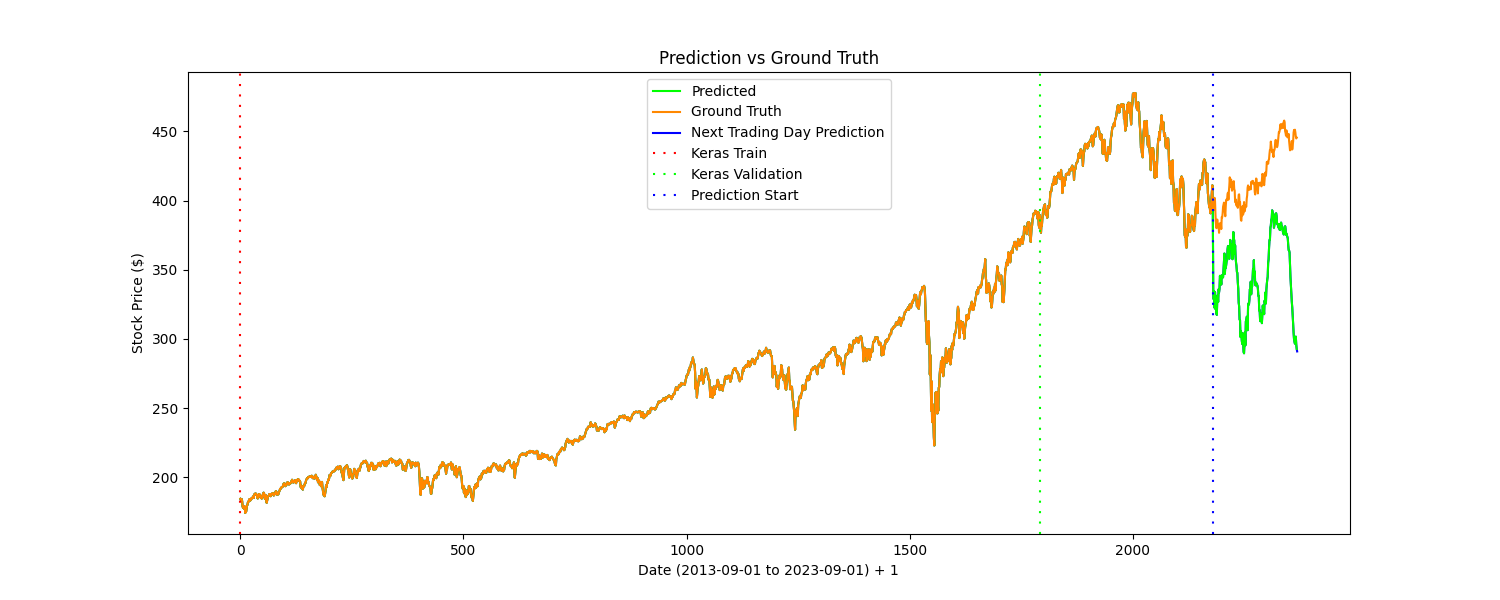

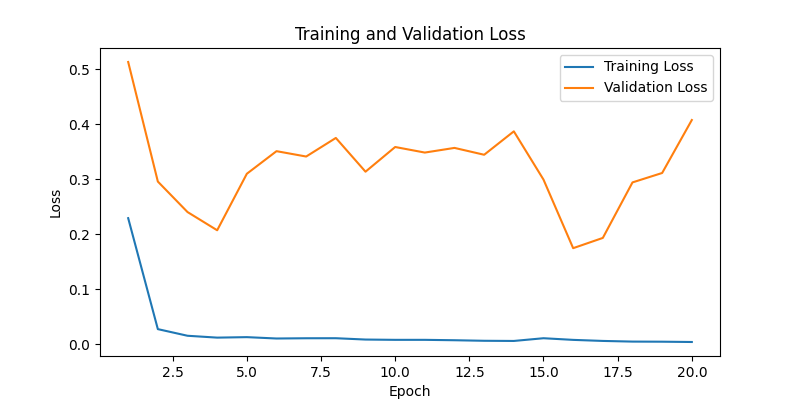

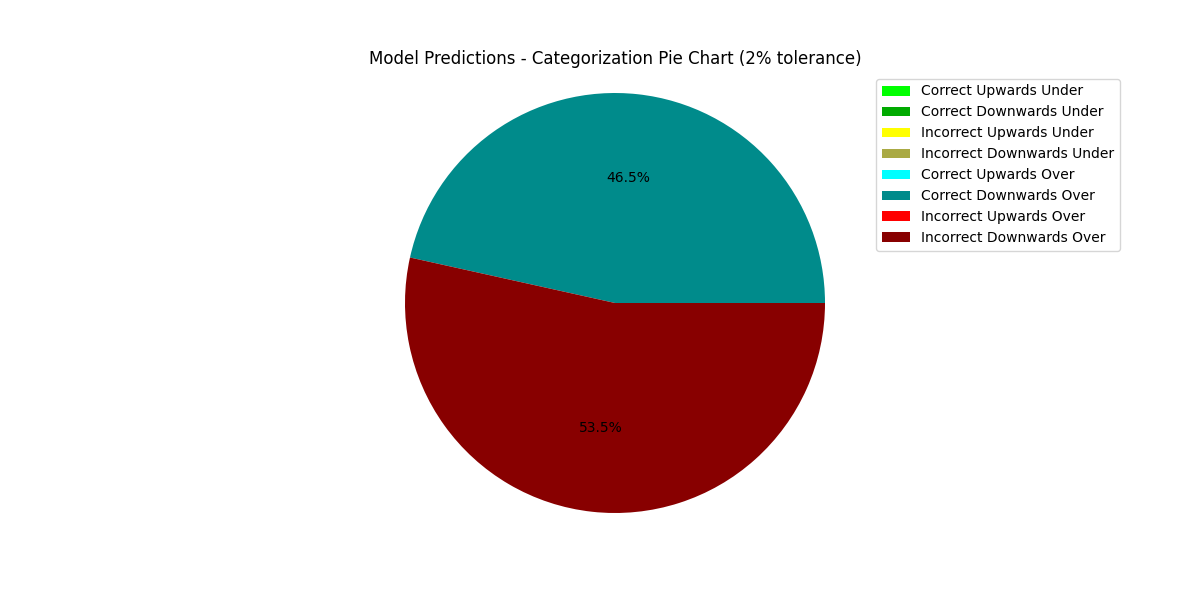

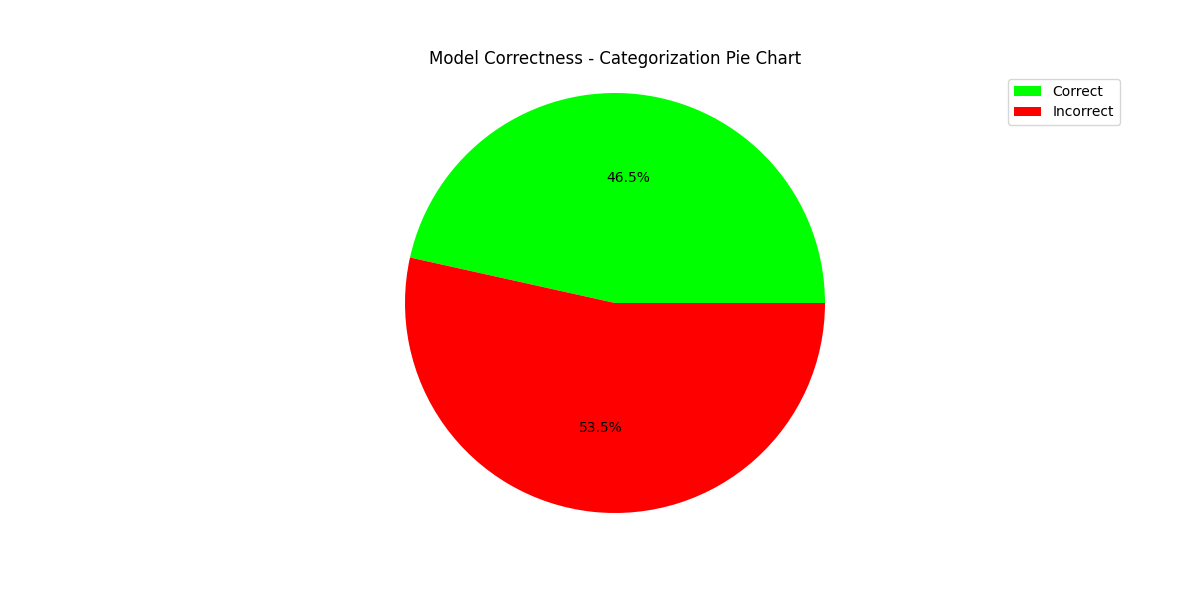

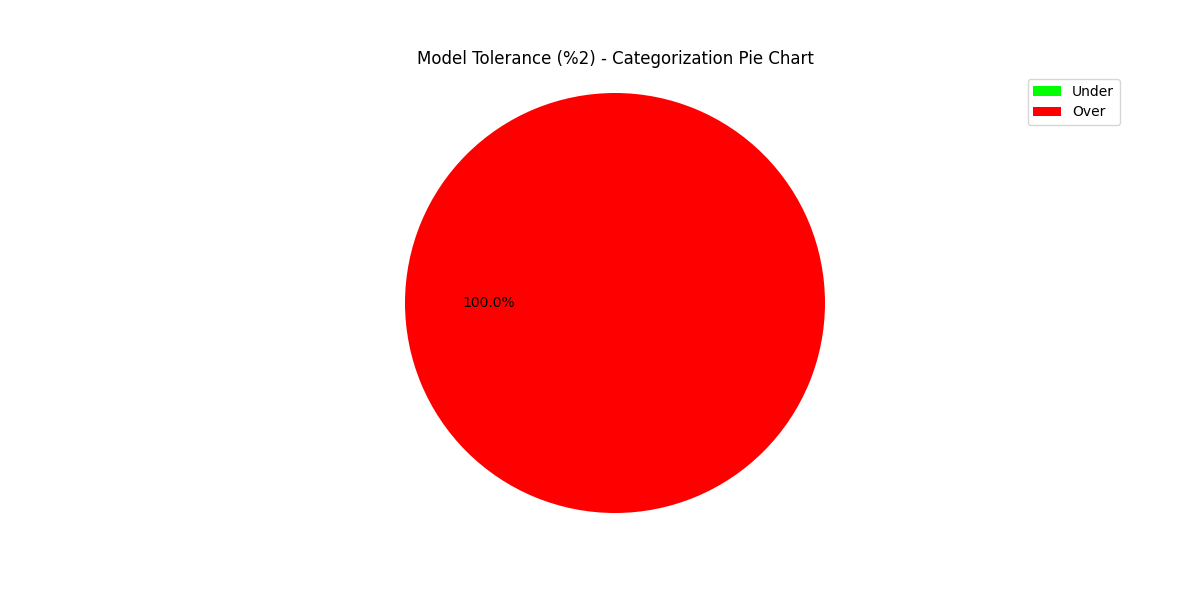

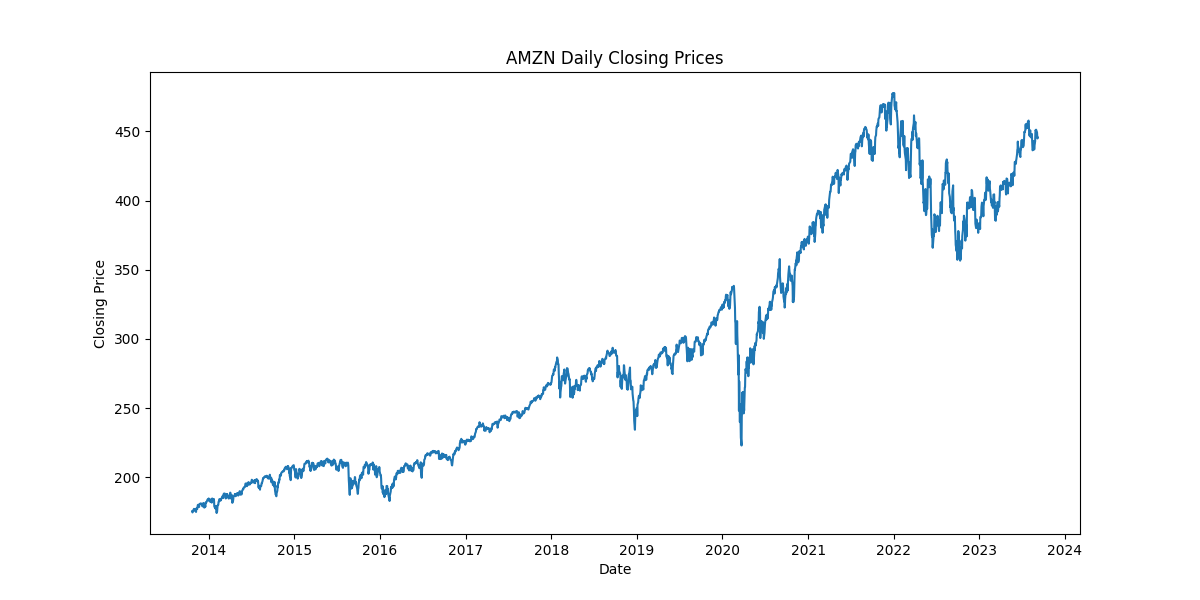

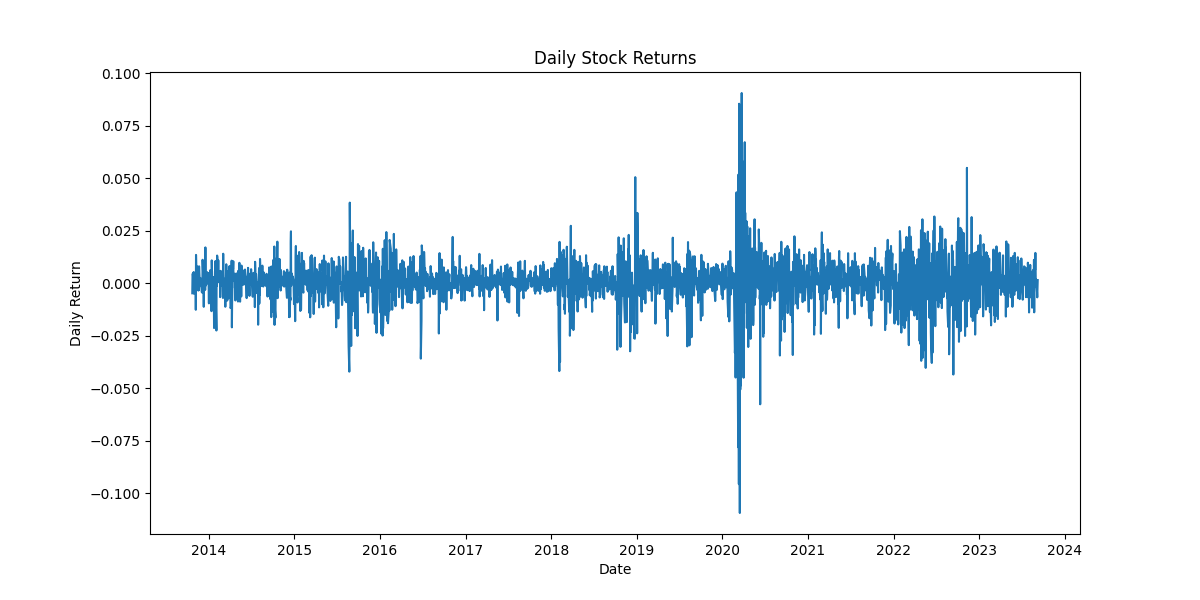

In [387]:
plot_prediction_vs_gt()
plot_loss_chart()
plot_pie_categories()
plot_pie_correctness()
plot_pie_tolerance()
plot_daily_close()
plot_daily_returns()